In [14]:
%matplotlib widget
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import find_peaks

# 设置中文字体为 wqy
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 使用文泉驿正黑字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [66]:
def calculate_threshold(red_channel, mask = None):
    if mask is not None:
        red_channel = cv.bitwise_and(red_channel, red_channel, mask=mask)
    hist = cv.calcHist([red_channel], [0], None, [256], [0, 256]).flatten()
    hist[0] = 0
    peaks, _ = find_peaks(hist)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    second_peak_index = sorted_peaks[1]
    min_val_after_peak = np.argmin(hist[second_peak_index:]) + second_peak_index
    return min_val_after_peak


def segment_image(src, threshold, kernel_size):
    _, src_bin = cv.threshold(src, threshold, 255, cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_OPEN, kernel)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_CLOSE, kernel)
    coords = cv.findNonZero(src_bin)
    contours, _ = cv.findContours(src_bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv.boundingRect(coords), None
    contour = max(contours, key=cv.contourArea)
    mask = np.zeros(src.shape, dtype=np.uint8)
    cv.drawContours(mask, [contour], -1, 1, thickness=cv.FILLED)
    return cv.boundingRect(coords), mask


def crop_to_bbox(frame, bbox):
    x, y, w, h = bbox
    return frame[y : y + h, x : x + w]


def read_frame(video_path, frame_number):
    cap = cv.VideoCapture(video_path)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}")
    return frame


def process_frame(frame):
    red_channel = frame[:, :, 2]
    threshold = calculate_threshold(red_channel)

    kernel_size = (5, 5)
    bbox, mask = segment_image(red_channel, threshold, kernel_size)
    red_channel = crop_to_bbox(red_channel, bbox)
    mask = crop_to_bbox(mask, bbox)

    threshold = calculate_threshold(red_channel, mask)
    _, binary_image = cv.threshold(red_channel, threshold, 255, cv.THRESH_BINARY_INV)

    # 一次13x13处理
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (13, 13))
    processed_image_13x13 = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
    processed_image_13x13 = cv.morphologyEx(processed_image_13x13, cv.MORPH_CLOSE, kernel)

    # 使用Canny边缘检测算法
    median = np.median(processed_image_13x13)
    edges = cv.Canny(processed_image_13x13, 0.66 * median, 1.33 * median)

    # 轮廓发现
    contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    min_length = 500  # 设置最小长度阈值
    circularity_threshold = 0.7 # 设置圆形度阈值

    filtered_contours = []
    for contour in contours:
        area = cv.contourArea(contour)
        perimeter = cv.arcLength(contour, True)
        if perimeter < min_length:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity >= circularity_threshold:
            filtered_contours.append(contour)

    # 在 cropped_frame 上绘制过滤后的轮廓
    cropped_frame = crop_to_bbox(frame, bbox)
    cv.drawContours(cropped_frame, filtered_contours, -1, (0, 255, 0), 2)  # 绿色轮廓
    return cropped_frame, binary_image, processed_image_13x13, edges


def display_images(images):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for ax, img in zip(axes, images):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.show()

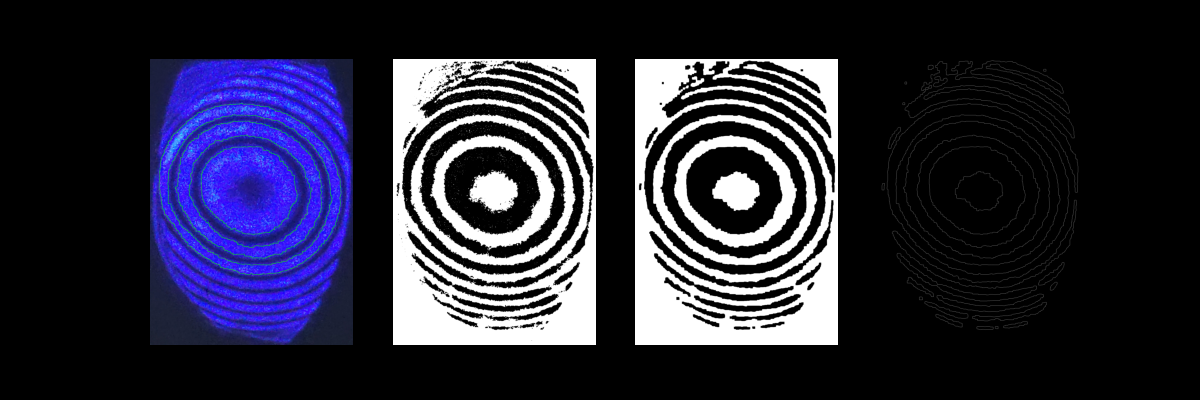

In [67]:
# 读取视频文件并加载前50帧到内存中
video_path = "真实场景.mp4"
frame_number = 100
frame = read_frame(video_path, frame_number)
images = process_frame(frame)
display_images(images)